In [1]:
import os 
from dotenv import load_dotenv 
load_dotenv() 
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
def multiply(a: int, b: int) -> int:
    """
    This function multiplies two numbers
    """
    return a * b 

def add(a: int, b: int) -> int:
    """
    This function adds two numbers
    """
    return a + b 

def subtract(a: int, b: int) -> int:
    """This function subtracts two numbers"""
    return a - b  

def divide(a: int, b: int) -> int:
    """This function divides two numbers"""
    return a / b 

In [3]:
tools = [multiply, add, subtract, divide] 

In [4]:
from langchain_openai import ChatOpenAI 
llm = ChatOpenAI(model = "gpt-4o-mini") 

In [5]:
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False) 

In [6]:
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, AnyMessage, SystemMessage 
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages, MessagesState 

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [7]:
sys_msg = SystemMessage(content= "You're a helpful assistant tasked with performing arithmetic operations on a sets of inputs.")

def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] +state["messages"])]}

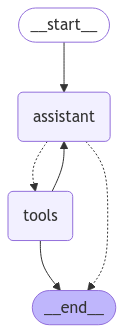

In [8]:
from langgraph.graph import StateGraph, START, END 
from langgraph.prebuilt import ToolNode, tools_condition 
from IPython.display import Image, display 

builder = StateGraph(MessagesState)
# Nodes 
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Edges  
builder.add_edge(START, "assistant") 
builder.add_conditional_edges("assistant", 
                              tools_condition)
builder.add_edge("tools", "assistant") 
builder.add_edge("tools", END) 

react_graph = builder.compile() 

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content = "What is 2 times 3", name = "Lance")] 
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

What is 2 times 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lwjix3AlYzMymrv8SVMpygMO)
 Call ID: call_lwjix3AlYzMymrv8SVMpygMO
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2 times 3 is 6.


In [11]:
messages = [HumanMessage(content = "Multiply by 2")] 
messages = react_graph.invoke({"messages": messages}) 
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply by 2
================================== Ai Message ==================================

Please provide a number that you would like to multiply by 2.


### **Memory in Agents using MemorySaver**

In [12]:
from langgraph.checkpoint.memory import MemorySaver 

memory = MemorySaver() 

react_graph = builder.compile(checkpointer=memory) 

In [13]:
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content = "Add 3 and 3")] 

messages = react_graph.invoke({"messages": messages}, config) 
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 3
================================== Ai Message ==================================
Tool Calls:
  add (call_TvUYI1d0RFTuhIam4o6iwVdT)
 Call ID: call_TvUYI1d0RFTuhIam4o6iwVdT
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: add

6
================================== Ai Message ==================================

The sum of 3 and 3 is 6.


In [14]:
messages = [HumanMessage(content = "Multiply that by 2")] 
messages = react_graph.invoke({"messages": messages}, config) 
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 3
================================== Ai Message ==================================
Tool Calls:
  add (call_TvUYI1d0RFTuhIam4o6iwVdT)
 Call ID: call_TvUYI1d0RFTuhIam4o6iwVdT
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: add

6
================================== Ai Message ==================================

The sum of 3 and 3 is 6.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_C7BSEGX0jucatInnEnXTfcIE)
 Call ID: call_C7BSEGX0jucatInnEnXTfcIE
  Args:
    a: 6
    b: 2
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The result of multiplyi

In [74]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Union, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [75]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [76]:
# Define tools
def create_title(topic: str) -> str:
    """Create a title for the given topic"""
    return f"Title: {topic}"

def create_content(topic: str) -> str:
    """Create content for the given topic"""
    return f"Content about {topic}"

In [77]:
# Initialize LLM and tools
llm = ChatOpenAI(model="gpt-3.5-turbo")
tools = [create_title, create_content]
llm_with_tools = llm.bind_tools(tools)

In [78]:
class ContentState(TypedDict):
    topic: str
    title: str
    content: str
    messages: Annotated[list[AnyMessage], add_messages]

In [79]:
def content_agent(state: ContentState) -> ContentState:
    """Agent to handle content creation decisions"""
    system_msg = SystemMessage(content="""You are a content creation assistant.
    Use the available tools to:
    1. First create a title using create_title
    2. Then create content using create_content
    Process one step at a time.""")
    
    response = llm_with_tools.invoke([system_msg] + state["messages"])
    
    return {
        "topic": state["topic"],
        "title": state["title"],
        "content": state["content"],
        "messages": state["messages"] + [response]
    }

In [80]:
def should_continue(state: ContentState) -> Union[Literal["continue"], Literal["end"]]:
    """Determine if we should continue processing"""
    last_message = state["messages"][-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, "additional_kwargs") and last_message.additional_kwargs.get("tool_calls"):
        return "continue"
    return "end"

In [82]:
# Create the graph
builder = StateGraph(ContentState)
# Add nodes
builder.add_node("content_agent", content_agent)
builder.add_node("tools", ToolNode(tools))
# Add edges 
builder.add_edge(START, "content_agent")
builder.add_conditional_edges(
    "content_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)
builder.add_edge("tools", "content_agent")
workflow = builder.compile()

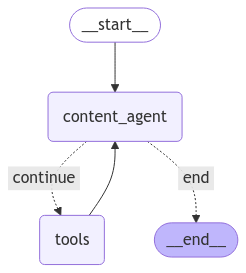

In [83]:
display(Image(workflow.get_graph().draw_mermaid_png()))


In [96]:
def generate_content(topic: str):
    """Function to generate content for a given topic"""
    initial_state = {
        "topic": topic,
        "title": "",
        "content": "",
        "messages": [HumanMessage(content=f"Create content about: {topic}")]
    }
    
    result = workflow.invoke(initial_state)

    print("\nGenerated Content:")
    print("---------------------")
    for message in result["messages"]:
        print(message.content)

In [97]:
generate_content("Artificial Intelligence and its impact on society")


Generated Content:
---------------------
Create content about: Artificial Intelligence and its impact on society

Title: Artificial Intelligence and its impact on society

Content about Artificial Intelligence and its impact on society
Artificial Intelligence (AI) has become a transformative force in society, impacting various aspects of human life. The integration of AI technologies has brought about significant changes in the way we live, work, and interact. From personalized recommendations on streaming platforms to autonomous vehicles on the roads, AI has permeated numerous sectors, revolutionizing processes and enhancing efficiency.

One of the key areas where AI is making a substantial impact is healthcare. Through the use of AI algorithms, medical professionals can analyze large volumes of data to diagnose diseases more accurately and develop personalized treatment plans. AI-powered tools can assist in predicting patient outcomes, identifying patterns in medical images, and eve